Ting Pan, github ID: [tingpan](https://github.com/tingpan)

# Applying K-means Algorithms on NBA Player Clustering

In the previous [project](http://dota666.com/basketball/), we just did a very simple statistics and visualization, which is not insightful and interesting. I think we could apply some unsupervised clustering (such as K-Means) with Shogun API on the dataset to classify the player into different types. 

This notebook shows clustering NBA Players into different types with K-means in Shogun. Since I do not know the optimal value of k, I will use K-means and Elbow Method to find out the most suitable value for k.

The first step is loading the dataset. The file `play_freq.data` contains play-type stats of NBA Season 2015-16 from [stats.nba.com](http://stats.nba.com/). This CSV file has 11 columns in total. The first column is the players' name and following ten columns are the frequency of ten play types (Transition, Isolation, Pick & Roll, Pick & Roll: Roll Man, Post-Up, Spot-Up, Hand-Off, Cut, Off Screen and Rebound).  There are nearly 400 players data in this file. The loaded data are the features for training.

In [2]:
from numpy import array

def load_data():
    f = open('./play_freq.data')
    features = []
    names = []
    for line in f:
        words = line.rstrip().split(',')
        # Store player names
        names.append(words[0])
        # Store features of each player
        features.append([float(i) for i in words[1:]])

    f.close()

    return (array(features).T, names)

data, names = load_data()

Now, Let's define a method for K-means cluster with Shogun Python API. 

In [3]:
from modshogun import *

def train_kmeans(k, data):
    train_features = RealFeatures(data)
    
    # calculate euclidean distance of features
    distance = EuclideanDistance(train_features, train_features)

    # initialize KMeans object
    kmeans = KMeans(k, distance, True)

    # training kmeans
    kmeans.train(train_features)

    # labels for data points
    result = kmeans.apply()
    centers = kmeans.get_cluster_centers()
    radiuses = kmeans.get_radiuses()
    
    return result, centers, radiuses

Now I can build a model using the dataset with a specified value for number of clusters, which is k.

In [4]:
# Specifying the number of clusters(k)
# However, the actual amount of types is unknown

k = 8
result, centers, radiuses = train_kmeans(k, data)

Since I don't know the optimal value of k, I will use Elbow Method to find out it. I will run K-means clustering on the dataset with an increasing k. For each k, I will calculate the loss. The best k would be the k with a small loss, and the trend of loss decreasing is diminishing.

I will run K-means with a range of k and calculate the sum of radiuses and for each k. To avoid the local minimum, I will train the dataset 10 times and get the average cost. (Since this is only a demo, I only train 10 times to increase the speed)

In [8]:
import numpy as np
ys = []
xs = []
player_count = len(data[0])
iter_count = 50
for k in range(5, 30):
        xs.append(k)
        _ys = []
        for i in range(0, iter_count):
            result, centers, radiuses = train_kmeans(k, data)
            for player_i in range(0, player_count):
                cluster_i = int(result[player_i])
                center = array([x[cluster_i] for x in centers])
                player = array([y[player_i] for y in data])
                _ys.append(np.sum((center - player)**2))
        ys.append(sum(_ys)/iter_count/player_count)

Then, I will plot a line chart of the average cost for each k. Can see that the line chart looks like an arm, and the "elbow" of the arm is the value of the best k.

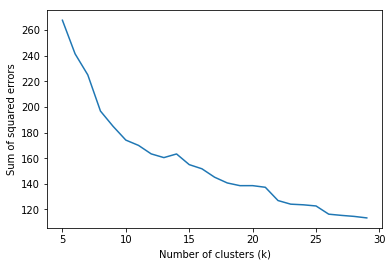

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(xs,ys)
plt.xlabel('Number of clusters (k)')
plt.ylabel('Sum of squared errors')
plt.show()

As shown in figure, the best k is around 13. As this is a real world dataset, so we could decide if this is a reasonable k by analysing real world cases.

As mentioned in [the explanation of play type data](https://github.com/tingpan/shogun-data#play-type-statsmost-important-stats-in-this-project), play type data shows when a player is on court, what type of action he is doing. Players in same cluster should have similar frequence of each play type.

In order to show whether this is the right k for clustering, I will visualise some clusters with bar chart and interpret why players should be in that cluster.

Here I will use bar chart to visualise one of the cluster:

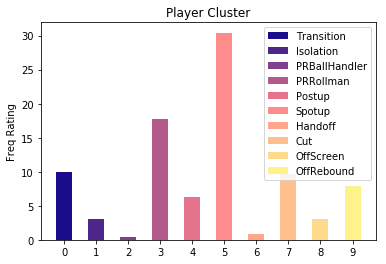

In [16]:
def draw_values(k, centers, index):
    ind = np.arange(10)
    width = 0.5
    headers = ['Transition', 'Isolation', 'PRBallHandler', 'PRRollman', 'Postup', 'Spotup', 'Handoff', 'Cut', 'OffScreen', 'OffRebound']
    fig, ax = plt.subplots()
    rects = plt.bar(ind, [values[index] for values in centers], width, color=[(min(x/10.0, 1), x/20.0, 0.55) for x in range(1,21,2)])
    ax.set_ylabel('Freq Rating')
    ax.set_title('Player Cluster')
    ax.set_xticks(ind)
    ax.legend(rects, headers)
    plt.show()
    
k = 13
result, centers, radiuses = train_kmeans(k, data)

draw_values(k, centers, 0)

Players in this type would have these characteristics:

1. Always catch-and-shoot/drive.
2. Catch-and-shoot/drive always comes after being Roll Man of Pick & Roll.
3. Always move quickly to catch a pass while moving toward and finish before the defense sets(after getting a rebound or possession changes).

Therefore, we would figure out players belongs to this type would be big man with ability to move fast and score both inside and outside. Then we get names of them:

In [17]:
def players(names, result, index):
    players = []
    for i, name in enumerate(names):
            if int(result[i]) == index:
                players.append(name)
    return players
            
print players(names, result, 0)

['Chris Bosh', 'Kristaps Porzingis', 'Serge Ibaka', 'Luol Deng', 'Mirza Teletovic', 'Nikola Mirotic', 'Marvin Williams', 'Ersan Ilyasova', 'Kelly Olynyk', 'Luis Scola', 'Terrence Jones', 'Meyers Leonard', 'Darrell Arthur', 'Jon Leuer', 'Jason Smith', 'Frank Kaminsky', 'Marreese Speights', 'Patrick Patterson', 'Andrea Bargnani', 'Paul Pierce', 'Kris Humphries', 'Trey Lyles', 'Spencer Hawes', 'Charlie Villanueva', 'Mike Scott', 'Channing Frye', 'Larry Nance Jr.', 'Chris McCullough', 'Ryan Kelly', 'Nemanja Bjelica', 'Jonas Jerebko', 'Quincy Acy', 'Noah Vonleh', 'Josh McRoberts', 'Drew Gooden', "Johnny O'Bryant", 'Kevin Garnett', 'Luc Mbah a Moute', 'Jason Thompson']


Then we found that most of them match the characteristics we listed before. For example, Chris Bosh and Kristaps Porzingis are all typical big man that could score both inside and outside. 

I will test anthoer cluster to validate the result:

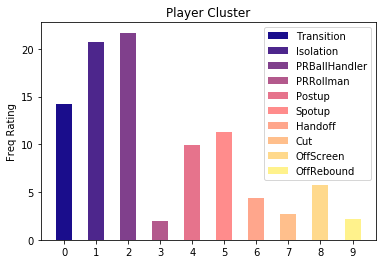

['James Harden', 'Kevin Durant', 'LeBron James', 'Carmelo Anthony', 'Kobe Bryant', 'Jamal Crawford']


In [18]:
draw_values(k, centers, 2)
print players(names, result, 2)

These players are the key player of their team, which means they always handle the ball. They also have the most percent of isolation. 

Therefore I have clustered players into 13 different types by their frequency of performing different play types on court. The next step of the project would be using this clustering result to predict game results.